In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 32)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 32)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2375 - acc: 0.2989
Epoch 00001: val_loss improved from inf to 1.81266, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_3_conv_checkpoint/001-1.8127.hdf5
36805/36805 [==============================] - 19s 507us/sample - loss: 2.2375 - acc: 0.2989 - val_loss: 1.8127 - val_acc: 0.4435
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6690 - acc: 0.4851
Epoch 00002: val_loss improved from 1.81266 to 1.58161, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_3_conv_checkpoint/002-1.5816.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 1.6691 - acc: 0.4851 - val_loss: 1.5816 - val_acc: 0.5167
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4584 - acc: 0.5523
Epoch 00003: val_loss improved from 1

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4531 - acc: 0.8579
Epoch 00026: val_loss did not improve from 1.35146
36805/36805 [==============================] - 17s 459us/sample - loss: 0.4532 - acc: 0.8579 - val_loss: 1.4553 - val_acc: 0.6096
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4324 - acc: 0.8660
Epoch 00027: val_loss did not improve from 1.35146
36805/36805 [==============================] - 17s 464us/sample - loss: 0.4323 - acc: 0.8660 - val_loss: 1.4397 - val_acc: 0.6131
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4184 - acc: 0.8681
Epoch 00028: val_loss did not improve from 1.35146
36805/36805 [==============================] - 17s 462us/sample - loss: 0.4183 - acc: 0.8681 - val_loss: 1.4285 - val_acc: 0.6147
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4059 - acc: 0.8715
Epoch 00029: val_loss did not improve from 1.35146
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9430
Epoch 00056: val_loss did not improve from 1.35146
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1854 - acc: 0.9429 - val_loss: 1.6294 - val_acc: 0.6567
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.9442
Epoch 00057: val_loss did not improve from 1.35146
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1784 - acc: 0.9442 - val_loss: 1.6371 - val_acc: 0.6557
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1719 - acc: 0.9477
Epoch 00058: val_loss did not improve from 1.35146
36805/36805 [==============================] - 17s 475us/sample - loss: 0.1719 - acc: 0.9478 - val_loss: 1.6221 - val_acc: 0.6578
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1711 - acc: 0.9468
Epoch 00059: val_loss did not improve from 1.35146
36805/36805 [=====

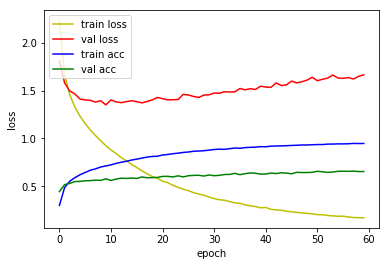

4815/4815 [==============================] - 2s 339us/sample - loss: 1.4481 - acc: 0.5468
Loss: 1.4480572943870647 Accuracy: 0.5468328

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2460 - acc: 0.2726
Epoch 00001: val_loss improved from inf to 1.79598, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_4_conv_checkpoint/001-1.7960.hdf5
36805/36805 [==============================] - 18s 491us/sample - loss: 2.2459 - acc: 0.2726 - val_loss: 1.7960 - val_acc: 0.4230
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6802 - acc: 0.4685
Epoch 00002: val_loss improved from 1.79598 to 1.50594, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_4_conv_checkpoint/002-1.5059.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 1.6801 - acc: 0.4685 - val_loss: 1.5059 - val_acc: 0.5323
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6029 - acc: 0.8133
Epoch 00023: val_loss did not improve from 0.91266
36805/36805 [==============================] - 17s 465us/sample - loss: 0.6029 - acc: 0.8133 - val_loss: 0.9455 - val_acc: 0.7186
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5837 - acc: 0.8208
Epoch 00024: val_loss did not improve from 0.91266
36805/36805 [==============================] - 17s 467us/sample - loss: 0.5837 - acc: 0.8209 - val_loss: 0.9318 - val_acc: 0.7305
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5636 - acc: 0.8229
Epoch 00025: val_loss improved from 0.91266 to 0.90152, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_4_conv_checkpoint/025-0.9015.hdf5
36805/36805 [==============================] - 17s 467us/sample - loss: 0.5635 - acc: 0.8229 - val_loss: 0.9015 - val_acc: 0.7338
Epoch 26/500
36800/36805 [============================>.

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2872 - acc: 0.9048
Epoch 00051: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 460us/sample - loss: 0.2872 - acc: 0.9048 - val_loss: 0.9459 - val_acc: 0.7559
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2882 - acc: 0.9052
Epoch 00052: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 458us/sample - loss: 0.2882 - acc: 0.9052 - val_loss: 0.9400 - val_acc: 0.7591
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2788 - acc: 0.9086
Epoch 00053: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 461us/sample - loss: 0.2788 - acc: 0.9086 - val_loss: 0.9395 - val_acc: 0.7638
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2712 - acc: 0.9115
Epoch 00054: val_loss did not improve from 0.89210
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1834 - acc: 0.9397
Epoch 00081: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 452us/sample - loss: 0.1833 - acc: 0.9397 - val_loss: 1.0204 - val_acc: 0.7710
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.9414
Epoch 00082: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 460us/sample - loss: 0.1763 - acc: 0.9414 - val_loss: 0.9932 - val_acc: 0.7789
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9404
Epoch 00083: val_loss did not improve from 0.89210
36805/36805 [==============================] - 17s 456us/sample - loss: 0.1781 - acc: 0.9404 - val_loss: 1.0382 - val_acc: 0.7678
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1701 - acc: 0.9437
Epoch 00084: val_loss did not improve from 0.89210
36805/36805 [=====

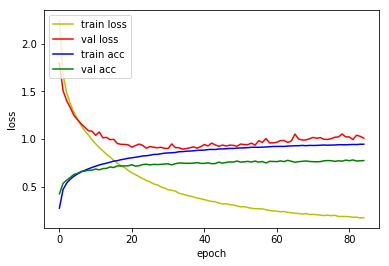

4815/4815 [==============================] - 1s 262us/sample - loss: 1.0127 - acc: 0.7124
Loss: 1.0127461109082152 Accuracy: 0.7123572

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3966 - acc: 0.2155
Epoch 00001: val_loss improved from inf to 1.85210, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/001-1.8521.hdf5
36805/36805 [==============================] - 19s 527us/sample - loss: 2.3965 - acc: 0.2156 - val_loss: 1.8521 - val_acc: 0.4093
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7607 - acc: 0.4265
Epoch 00002: val_loss improved from 1.85210 to 1.57533, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/002-1.5753.hdf5
36805/36805 [==============================] - 17s 465us/sample - loss: 1.7609 - acc: 0.4265 - val_loss: 1.5753 - val_acc: 0.5020
Epoch 3/500
36800/36805 [====================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7032 - acc: 0.7877
Epoch 00022: val_loss improved from 0.73492 to 0.71091, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/022-0.7109.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.7031 - acc: 0.7877 - val_loss: 0.7109 - val_acc: 0.7939
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6807 - acc: 0.7924
Epoch 00023: val_loss improved from 0.71091 to 0.69184, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/023-0.6918.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.6806 - acc: 0.7925 - val_loss: 0.6918 - val_acc: 0.7990
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6624 - acc: 0.8003
Epoch 00024: val_loss improved from 0.69184 to 0.69110, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3991 - acc: 0.8765
Epoch 00047: val_loss improved from 0.52743 to 0.52591, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/047-0.5259.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.3991 - acc: 0.8765 - val_loss: 0.5259 - val_acc: 0.8574
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3864 - acc: 0.8811
Epoch 00048: val_loss did not improve from 0.52591
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3863 - acc: 0.8812 - val_loss: 0.5260 - val_acc: 0.8542
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.8853
Epoch 00049: val_loss improved from 0.52591 to 0.52430, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/049-0.5243.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.37

36800/36805 [============================>.] - ETA: 0s - loss: 0.2581 - acc: 0.9177
Epoch 00073: val_loss did not improve from 0.49718
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2581 - acc: 0.9177 - val_loss: 0.5063 - val_acc: 0.8665
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2602 - acc: 0.9168
Epoch 00074: val_loss improved from 0.49718 to 0.49600, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_5_conv_checkpoint/074-0.4960.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2602 - acc: 0.9168 - val_loss: 0.4960 - val_acc: 0.8686
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2562 - acc: 0.9163
Epoch 00075: val_loss did not improve from 0.49600
36805/36805 [==============================] - 17s 462us/sample - loss: 0.2562 - acc: 0.9163 - val_loss: 0.5000 - val_acc: 0.8677
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9380
Epoch 00101: val_loss did not improve from 0.48867
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1890 - acc: 0.9380 - val_loss: 0.5064 - val_acc: 0.8768
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1870 - acc: 0.9371
Epoch 00102: val_loss did not improve from 0.48867
36805/36805 [==============================] - 17s 475us/sample - loss: 0.1869 - acc: 0.9372 - val_loss: 0.5069 - val_acc: 0.8803
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9375
Epoch 00103: val_loss did not improve from 0.48867
36805/36805 [==============================] - 17s 466us/sample - loss: 0.1863 - acc: 0.9375 - val_loss: 0.4960 - val_acc: 0.8812
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9381
Epoch 00104: val_loss did not improve from 0.48867
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1488 - acc: 0.9504
Epoch 00130: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 460us/sample - loss: 0.1488 - acc: 0.9504 - val_loss: 0.5115 - val_acc: 0.8852
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9506
Epoch 00131: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 462us/sample - loss: 0.1478 - acc: 0.9506 - val_loss: 0.5044 - val_acc: 0.8891
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9519
Epoch 00132: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 460us/sample - loss: 0.1447 - acc: 0.9519 - val_loss: 0.5039 - val_acc: 0.8877
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9525
Epoch 00133: val_loss did not improve from 0.48315
36805/36805 [===============

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9596
Epoch 00160: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 471us/sample - loss: 0.1224 - acc: 0.9596 - val_loss: 0.5200 - val_acc: 0.8861
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1221 - acc: 0.9600
Epoch 00161: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 468us/sample - loss: 0.1221 - acc: 0.9600 - val_loss: 0.5213 - val_acc: 0.8903
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9593
Epoch 00162: val_loss did not improve from 0.48315
36805/36805 [==============================] - 17s 462us/sample - loss: 0.1216 - acc: 0.9594 - val_loss: 0.5123 - val_acc: 0.8891
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9611
Epoch 00163: val_loss did not improve from 0.48315
36805/36805 [=

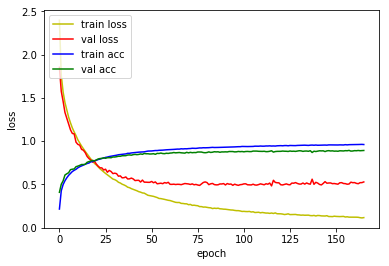

4815/4815 [==============================] - 1s 284us/sample - loss: 0.6059 - acc: 0.8536
Loss: 0.6059250388561379 Accuracy: 0.85358256

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3579 - acc: 0.2267
Epoch 00001: val_loss improved from inf to 1.79336, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/001-1.7934.hdf5
36805/36805 [==============================] - 20s 549us/sample - loss: 2.3577 - acc: 0.2268 - val_loss: 1.7934 - val_acc: 0.4405
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7049 - acc: 0.4499
Epoch 00002: val_loss improved from 1.79336 to 1.45283, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/002-1.4528.hdf5
36805/36805 [==============================] - 18s 484us/sample - loss: 1.7049 - acc: 0.4500 - val_loss: 1.4528 - val_acc: 0.5609
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5485 - acc: 0.8328
Epoch 00022: val_loss improved from 0.49247 to 0.47317, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/022-0.4732.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 0.5486 - acc: 0.8328 - val_loss: 0.4732 - val_acc: 0.8633
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5304 - acc: 0.8375
Epoch 00023: val_loss improved from 0.47317 to 0.46507, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/023-0.4651.hdf5
36805/36805 [==============================] - 18s 487us/sample - loss: 0.5305 - acc: 0.8375 - val_loss: 0.4651 - val_acc: 0.8614
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5129 - acc: 0.8454
Epoch 00024: val_loss improved from 0.46507 to 0.45830, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkp

36800/36805 [============================>.] - ETA: 0s - loss: 0.3132 - acc: 0.9021
Epoch 00045: val_loss did not improve from 0.31234
36805/36805 [==============================] - 18s 481us/sample - loss: 0.3132 - acc: 0.9021 - val_loss: 0.3224 - val_acc: 0.9085
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3104 - acc: 0.9014
Epoch 00046: val_loss improved from 0.31234 to 0.31150, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/046-0.3115.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 0.3105 - acc: 0.9014 - val_loss: 0.3115 - val_acc: 0.9096
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3051 - acc: 0.9041
Epoch 00047: val_loss improved from 0.31150 to 0.29692, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/047-0.2969.hdf5
36805/36805 [==============================] - 18s 484us/sample - loss: 0.3050 - acc: 0.9

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2182 - acc: 0.9291
Epoch 00071: val_loss improved from 0.26268 to 0.25711, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv_checkpoint/071-0.2571.hdf5
36805/36805 [==============================] - 18s 485us/sample - loss: 0.2181 - acc: 0.9291 - val_loss: 0.2571 - val_acc: 0.9329
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9325
Epoch 00072: val_loss did not improve from 0.25711
36805/36805 [==============================] - 18s 485us/sample - loss: 0.2105 - acc: 0.9325 - val_loss: 0.2623 - val_acc: 0.9290
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9303
Epoch 00073: val_loss did not improve from 0.25711
36805/36805 [==============================] - 18s 482us/sample - loss: 0.2141 - acc: 0.9303 - val_loss: 0.2648 - val_acc: 0.9299
Epoch 74/500
36800/36805 [============================>.

Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1587 - acc: 0.9480
Epoch 00099: val_loss did not improve from 0.24505
36805/36805 [==============================] - 18s 490us/sample - loss: 0.1587 - acc: 0.9480 - val_loss: 0.2534 - val_acc: 0.9320
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9479
Epoch 00100: val_loss did not improve from 0.24505
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1560 - acc: 0.9479 - val_loss: 0.2464 - val_acc: 0.9355
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1554 - acc: 0.9473
Epoch 00101: val_loss did not improve from 0.24505
36805/36805 [==============================] - 18s 485us/sample - loss: 0.1555 - acc: 0.9473 - val_loss: 0.2562 - val_acc: 0.9345
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9486
Epoch 00102: val_loss did not improve from 0.24505
36805/36805 [==

Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9614
Epoch 00128: val_loss did not improve from 0.24243
36805/36805 [==============================] - 18s 492us/sample - loss: 0.1179 - acc: 0.9614 - val_loss: 0.2585 - val_acc: 0.9362
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9588
Epoch 00129: val_loss did not improve from 0.24243
36805/36805 [==============================] - 18s 497us/sample - loss: 0.1198 - acc: 0.9588 - val_loss: 0.2676 - val_acc: 0.9364
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1167 - acc: 0.9598
Epoch 00130: val_loss did not improve from 0.24243
36805/36805 [==============================] - 17s 471us/sample - loss: 0.1167 - acc: 0.9598 - val_loss: 0.2837 - val_acc: 0.9299
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9600
Epoch 00131: val_loss did not improve from 0.24243
36805/36805 [=

Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9689
Epoch 00158: val_loss did not improve from 0.24243
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0934 - acc: 0.9689 - val_loss: 0.2759 - val_acc: 0.9394
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9691
Epoch 00159: val_loss did not improve from 0.24243
36805/36805 [==============================] - 18s 497us/sample - loss: 0.0916 - acc: 0.9691 - val_loss: 0.2581 - val_acc: 0.9383
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9673
Epoch 00160: val_loss did not improve from 0.24243
36805/36805 [==============================] - 18s 500us/sample - loss: 0.0942 - acc: 0.9673 - val_loss: 0.2679 - val_acc: 0.9397
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0909 - acc: 0.9693
Epoch 00161: val_loss did not improve from 0.24243
36805/36805 [=

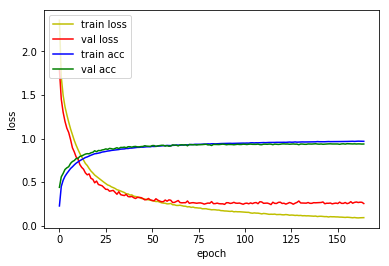

4815/4815 [==============================] - 1s 292us/sample - loss: 0.2991 - acc: 0.9184
Loss: 0.2990781063602721 Accuracy: 0.9183801

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5098 - acc: 0.1788
Epoch 00001: val_loss improved from inf to 1.91540, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/001-1.9154.hdf5
36805/36805 [==============================] - 22s 595us/sample - loss: 2.5098 - acc: 0.1788 - val_loss: 1.9154 - val_acc: 0.4132
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7599 - acc: 0.4234
Epoch 00002: val_loss improved from 1.91540 to 1.38253, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/002-1.3825.hdf5
36805/36805 [==============================] - 19s 510us/sample - loss: 1.7598 - acc: 0.4234 - val_loss: 1.3825 - val_acc: 0.5563
Epoch 3/500
36800/36805 [====================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4268 - acc: 0.8658
Epoch 00022: val_loss improved from 0.33619 to 0.31545, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/022-0.3155.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 0.4267 - acc: 0.8658 - val_loss: 0.3155 - val_acc: 0.9073
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4170 - acc: 0.8708
Epoch 00023: val_loss did not improve from 0.31545
36805/36805 [==============================] - 18s 498us/sample - loss: 0.4170 - acc: 0.8708 - val_loss: 0.3197 - val_acc: 0.9071
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4006 - acc: 0.8739
Epoch 00024: val_loss improved from 0.31545 to 0.31308, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/024-0.3131.hdf5
36805/36805 [==============================] - 18s 498us/sample - loss: 0.40

36800/36805 [============================>.] - ETA: 0s - loss: 0.2370 - acc: 0.9235
Epoch 00046: val_loss improved from 0.19595 to 0.19123, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/046-0.1912.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 0.2369 - acc: 0.9235 - val_loss: 0.1912 - val_acc: 0.9425
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2386 - acc: 0.9230
Epoch 00047: val_loss did not improve from 0.19123
36805/36805 [==============================] - 18s 492us/sample - loss: 0.2386 - acc: 0.9231 - val_loss: 0.2028 - val_acc: 0.9383
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2256 - acc: 0.9279
Epoch 00048: val_loss did not improve from 0.19123
36805/36805 [==============================] - 19s 509us/sample - loss: 0.2256 - acc: 0.9279 - val_loss: 0.1945 - val_acc: 0.9413
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1592 - acc: 0.9475
Epoch 00072: val_loss did not improve from 0.15630
36805/36805 [==============================] - 18s 503us/sample - loss: 0.1592 - acc: 0.9475 - val_loss: 0.1710 - val_acc: 0.9483
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9475
Epoch 00073: val_loss improved from 0.15630 to 0.15606, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_7_conv_checkpoint/073-0.1561.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 0.1597 - acc: 0.9475 - val_loss: 0.1561 - val_acc: 0.9541
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1605 - acc: 0.9466
Epoch 00074: val_loss did not improve from 0.15606
36805/36805 [==============================] - 19s 503us/sample - loss: 0.1605 - acc: 0.9466 - val_loss: 0.1648 - val_acc: 0.9506
Epoch 75/500
36800/36805 [============================>.

Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9601
Epoch 00100: val_loss did not improve from 0.14187
36805/36805 [==============================] - 19s 504us/sample - loss: 0.1186 - acc: 0.9601 - val_loss: 0.1441 - val_acc: 0.9581
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1157 - acc: 0.9597
Epoch 00101: val_loss did not improve from 0.14187
36805/36805 [==============================] - 19s 512us/sample - loss: 0.1157 - acc: 0.9597 - val_loss: 0.1429 - val_acc: 0.9613
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9616
Epoch 00102: val_loss did not improve from 0.14187
36805/36805 [==============================] - 19s 514us/sample - loss: 0.1131 - acc: 0.9616 - val_loss: 0.1621 - val_acc: 0.9560
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1115 - acc: 0.9616
Epoch 00103: val_loss did not improve from 0.14187
36805/36805 [=

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9686
Epoch 00130: val_loss did not improve from 0.14187
36805/36805 [==============================] - 18s 497us/sample - loss: 0.0920 - acc: 0.9686 - val_loss: 0.1462 - val_acc: 0.9609
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9689
Epoch 00131: val_loss did not improve from 0.14187
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0890 - acc: 0.9689 - val_loss: 0.1695 - val_acc: 0.9548
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9717
Epoch 00132: val_loss did not improve from 0.14187
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0844 - acc: 0.9717 - val_loss: 0.1508 - val_acc: 0.9590
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9704
Epoch 00133: val_loss did not improve from 0.14187
36805/36805 [=

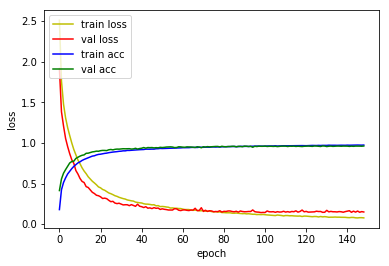

4815/4815 [==============================] - 2s 319us/sample - loss: 0.2009 - acc: 0.9396
Loss: 0.200893817667154 Accuracy: 0.9395639

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4652 - acc: 0.1885
Epoch 00001: val_loss improved from inf to 1.73186, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/001-1.7319.hdf5
36805/36805 [==============================] - 25s 676us/sample - loss: 2.4643 - acc: 0.1887 - val_loss: 1.7319 - val_acc: 0.4563
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6584 - acc: 0.4522
Epoch 00002: val_loss improved from 1.73186 to 1.24683, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/002-1.2468.hdf5
36805/36805 [==============================] - 20s 532us/sample - loss: 1.6583 - acc: 0.4522 - val_loss: 1.2468 - val_acc: 0.6280
Epoch 3/500
36736/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3351 - acc: 0.8938
Epoch 00022: val_loss improved from 0.23881 to 0.23874, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/022-0.2387.hdf5
36805/36805 [==============================] - 20s 535us/sample - loss: 0.3351 - acc: 0.8938 - val_loss: 0.2387 - val_acc: 0.9287
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3193 - acc: 0.8994
Epoch 00023: val_loss did not improve from 0.23874
36805/36805 [==============================] - 19s 520us/sample - loss: 0.3192 - acc: 0.8994 - val_loss: 0.2413 - val_acc: 0.9245
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3137 - acc: 0.9008
Epoch 00024: val_loss improved from 0.23874 to 0.22198, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/024-0.2220.hdf5
36805/36805 [==============================] - 20s 532us/sample - loss: 0.3136 - acc: 0.9

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9428
Epoch 00047: val_loss improved from 0.15773 to 0.15460, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/047-0.1546.hdf5
36805/36805 [==============================] - 19s 523us/sample - loss: 0.1758 - acc: 0.9428 - val_loss: 0.1546 - val_acc: 0.9506
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9435
Epoch 00048: val_loss did not improve from 0.15460
36805/36805 [==============================] - 20s 530us/sample - loss: 0.1735 - acc: 0.9435 - val_loss: 0.1638 - val_acc: 0.9497
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1679 - acc: 0.9470
Epoch 00049: val_loss improved from 0.15460 to 0.15324, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv_checkpoint/049-0.1532.hdf5
36805/36805 [==============================] - 20s 532us/sample - loss: 0.16

Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1089 - acc: 0.9633
Epoch 00075: val_loss did not improve from 0.14380
36805/36805 [==============================] - 19s 523us/sample - loss: 0.1089 - acc: 0.9633 - val_loss: 0.1512 - val_acc: 0.9560
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9639
Epoch 00076: val_loss did not improve from 0.14380
36805/36805 [==============================] - 19s 518us/sample - loss: 0.1084 - acc: 0.9639 - val_loss: 0.1522 - val_acc: 0.9567
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9645
Epoch 00077: val_loss did not improve from 0.14380
36805/36805 [==============================] - 19s 516us/sample - loss: 0.1088 - acc: 0.9645 - val_loss: 0.1612 - val_acc: 0.9536
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1050 - acc: 0.9651
Epoch 00078: val_loss did not improve from 0.14380
36805/36805 [=====

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9757
Epoch 00104: val_loss did not improve from 0.14313
36805/36805 [==============================] - 20s 530us/sample - loss: 0.0719 - acc: 0.9757 - val_loss: 0.1595 - val_acc: 0.9574
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9755
Epoch 00105: val_loss did not improve from 0.14313
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0720 - acc: 0.9755 - val_loss: 0.1556 - val_acc: 0.9574
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9765
Epoch 00106: val_loss did not improve from 0.14313
36805/36805 [==============================] - 19s 530us/sample - loss: 0.0702 - acc: 0.9765 - val_loss: 0.1657 - val_acc: 0.9546
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9747
Epoch 00107: val_loss did not improve from 0.14313
36805/36805 [=


1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv Model


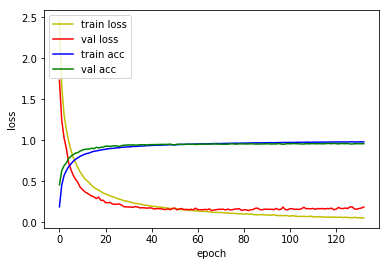

4815/4815 [==============================] - 2s 315us/sample - loss: 0.2448 - acc: 0.9329
Loss: 0.2447861482359291 Accuracy: 0.93291795



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
_________________________________________________________

4815/4815 [==============================] - 2s 325us/sample - loss: 0.6059 - acc: 0.8536
Loss: 0.6059250388561379 Accuracy: 0.85358256

1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (Ma

4815/4815 [==============================] - 2s 348us/sample - loss: 0.2009 - acc: 0.9396
Loss: 0.200893817667154 Accuracy: 0.9395639

1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxP

In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
_________________________________________________________

4815/4815 [==============================] - 2s 388us/sample - loss: 0.6556 - acc: 0.8638
Loss: 0.6555810355261231 Accuracy: 0.8637591

1D_CNN_custom_multi_2_concat_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (Max

4815/4815 [==============================] - 2s 421us/sample - loss: 0.1996 - acc: 0.9462
Loss: 0.1996189715675352 Accuracy: 0.9462098

1D_CNN_custom_multi_2_concat_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (Max